# Kaggle: Store Item Demand Forecasting Challenge

Kaggle [Store Item Demand Forecasting Challenge][kaggle] コンペの中の、
Kaggle Notebooks [My First Time Series Comp (Added Prophet)][adityaecdrid] を見ながら
データセットを確認します。
主に "Necessary Imports" の章に書かれている基本的なデータセットの確認までを対象としています。

[kaggle]: https://www.kaggle.com/c/demand-forecasting-kernels-only/overview
[adityaecdrid]: https://www.kaggle.com/adityaecdrid/my-first-time-series-comp-added-prophet


## パッケージの追加

In [1]:
!pip install kaggle

## Import

In [0]:
# default packages
import logging
import pathlib

In [3]:
# third party packages
import google.colab.drive as drive
import IPython.display as display
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import statsmodels.api as sm

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [0]:
# auto reload
%load_ext autoreload
%autoreload 2

In [0]:
# graph settigns
sns.set()

In [0]:
# logger
logger = logging.getLogger(__name__)
logging.basicConfig(level=logging.INFO)

## フォルダ構成の生成

In [0]:
data_dir = pathlib.Path("data")
raw_dir = data_dir.joinpath("raw")

data_dir.mkdir(exist_ok=True)
raw_dir.mkdir(exist_ok=True)

## Google Drive のマウント


In [8]:
def mount_gdrive() -> pathlib.Path:
    """Google Drive をマウントし、必要なディレクトリへのシンボリックリンクを設定する."""
    gdrive_base = pathlib.Path("/content/drive")
    gdrive_cache = gdrive_base.joinpath("My Drive/storeItemDemandForecastingChallenge")
    gdrive_kaggle = gdrive_base.joinpath("My Drive/kaggle")

    kaggle_dir = pathlib.Path("./kaggle")
    cache_dir = pathlib.Path("./cache")

    if gdrive_base.exists() is False:
        drive.mount(str(gdrive_base))
    if cache_dir.exists() is False:
        !ln -s "$gdrive_cache" "$cache_dir"
    if kaggle_dir.exists() is False:
        !ln -s "$gdrive_kaggle" "$kaggle_dir"

    return cache_dir, kaggle_dir


cache_dir, kaggle_dir = mount_gdrive()

ln: failed to create symbolic link 'cache': File exists


## Kaggle API の有効化

In [0]:
def activate_kaggle_api(gdrive_kaggle: pathlib.Path) -> None:
    """Kaggle API を有効化するための token を Google Drive からコピーする."""
    kaggle_file = "kaggle.json"
    gdrive_kaggle_json = gdrive_kaggle.joinpath(kaggle_file)
    local_kaggle_dir = pathlib.Path("/root/.kaggle")
    local_kaggle_json = local_kaggle_dir.joinpath(kaggle_file)

    local_kaggle_dir.mkdir(exist_ok=True)
    !cp "$gdrive_kaggle_json" "$local_kaggle_json"
    !chmod 600 "$local_kaggle_json"


activate_kaggle_api(kaggle_dir)

## データセットの読み込み

In [10]:
!kaggle competitions download -c demand-forecasting-kernels-only -p "$raw_dir"

test.csv: Skipping, found more recently modified local copy (use --force to force download)
train.csv.zip: Skipping, found more recently modified local copy (use --force to force download)
sample_submission.csv: Skipping, found more recently modified local copy (use --force to force download)


In [0]:
df_raw = pd.read_csv(raw_dir.joinpath("train.csv.zip"), low_memory=False, parse_dates=["date"], index_col=["date"])
df_test = pd.read_csv(raw_dir.joinpath("test.csv"), low_memory=False, parse_dates=["date"], index_col=["date"])
df_subs = pd.read_csv(raw_dir.joinpath("sample_submission.csv"))

In [12]:
display.display(df_raw.info())
display.display(df_raw.head())
display.display(df_raw.tail())

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 913000 entries, 2013-01-01 to 2017-12-31
Data columns (total 3 columns):
 #   Column  Non-Null Count   Dtype
---  ------  --------------   -----
 0   store   913000 non-null  int64
 1   item    913000 non-null  int64
 2   sales   913000 non-null  int64
dtypes: int64(3)
memory usage: 27.9 MB


None

,store,item,sales
date,,,
2013-01-01,1,1,13
2013-01-02,1,1,11
2013-01-03,1,1,14
2013-01-04,1,1,13
2013-01-05,1,1,10


,store,item,sales
date,,,
2017-12-27,10,50,63
2017-12-28,10,50,59
2017-12-29,10,50,74
2017-12-30,10,50,62
2017-12-31,10,50,82


In [13]:
display.display(df_test.info())
display.display(df_test.head())
display.display(df_test.tail())

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 45000 entries, 2018-01-01 to 2018-03-31
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype
---  ------  --------------  -----
 0   id      45000 non-null  int64
 1   store   45000 non-null  int64
 2   item    45000 non-null  int64
dtypes: int64(3)
memory usage: 1.4 MB


None

,id,store,item
date,,,
2018-01-01,0,1,1
2018-01-02,1,1,1
2018-01-03,2,1,1
2018-01-04,3,1,1
2018-01-05,4,1,1


,id,store,item
date,,,
2018-03-27,44995,10,50
2018-03-28,44996,10,50
2018-03-29,44997,10,50
2018-03-30,44998,10,50
2018-03-31,44999,10,50


In [14]:
display.display(df_subs.info())
display.display(df_subs.head())
display.display(df_subs.tail())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 45000 entries, 0 to 44999
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype
---  ------  --------------  -----
 0   id      45000 non-null  int64
 1   sales   45000 non-null  int64
dtypes: int64(2)
memory usage: 703.2 KB


None

,id,sales
0,0,52
1,1,52
2,2,52
3,3,52
4,4,52


,id,sales
44995,44995,52
44996,44996,52
44997,44997,52
44998,44998,52
44999,44999,52


## Salse を可視化

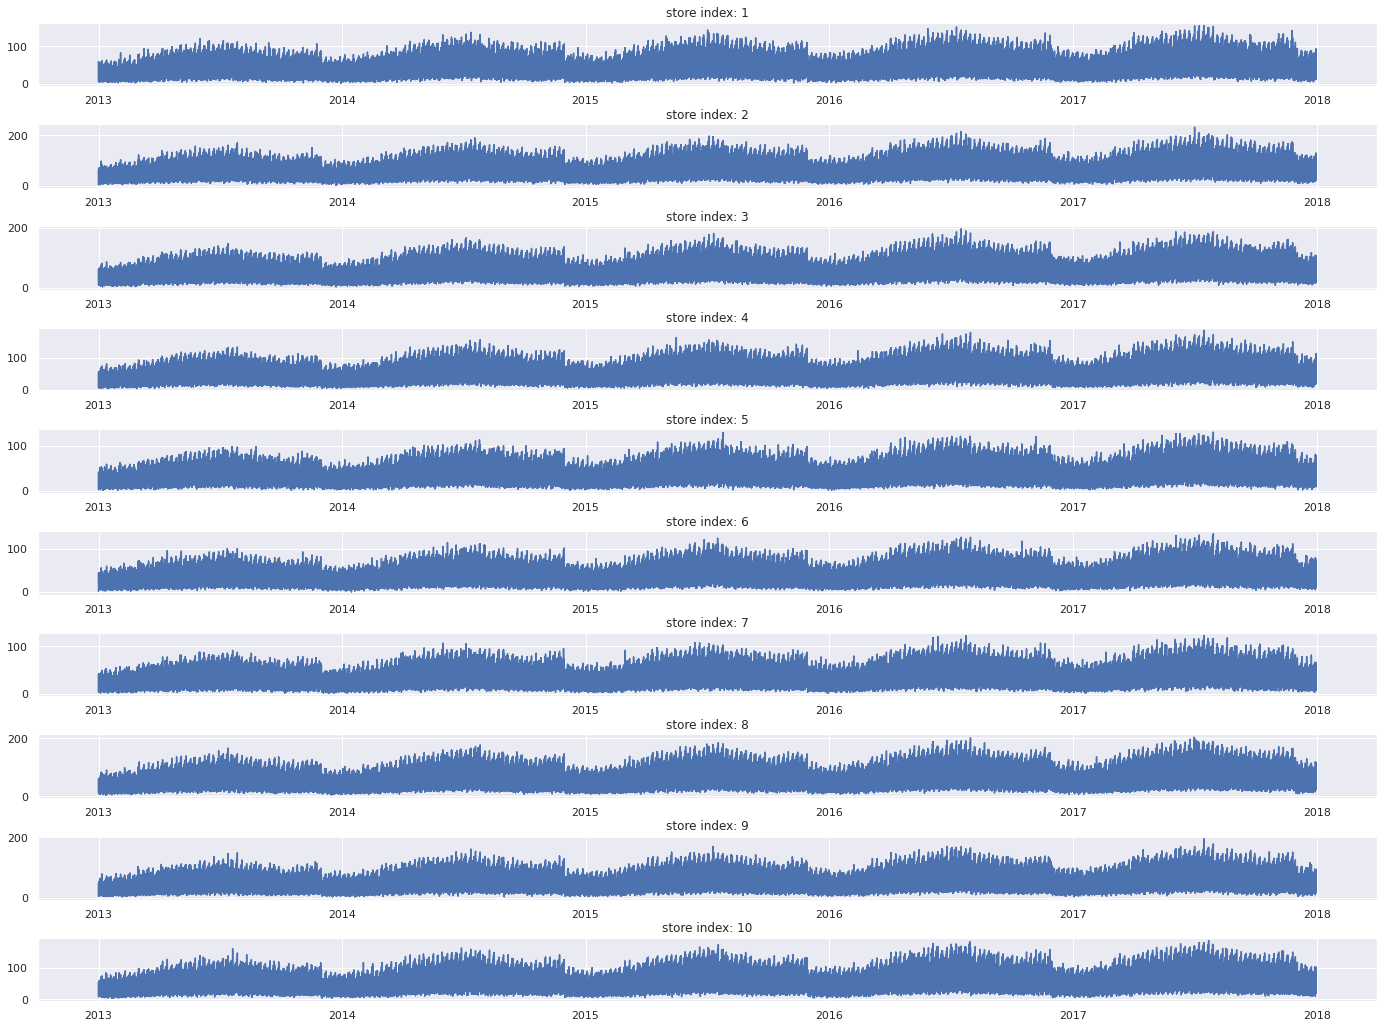

In [15]:
def plot_store_sales(df_target: pd.DataFrame) -> None:
    """単純にすべての値を Store 単位で出力する."""
    groups = df_target.groupby(["store"])

    plt.figure(figsize=(24, 18))
    plt.subplots_adjust(wspace=0.4, hspace=0.6)
    rows, cols = len(groups), 1
    for idx, (store, group) in enumerate(groups):
        df = group.sort_index()
        plt.subplot(rows, cols, idx + 1)
        plt.plot(df.index, df["sales"])
        plt.title(f"store index: {store}")
    plt.show()
    plt.cla()
    plt.clf()
    plt.close()


plot_store_sales(df_raw)

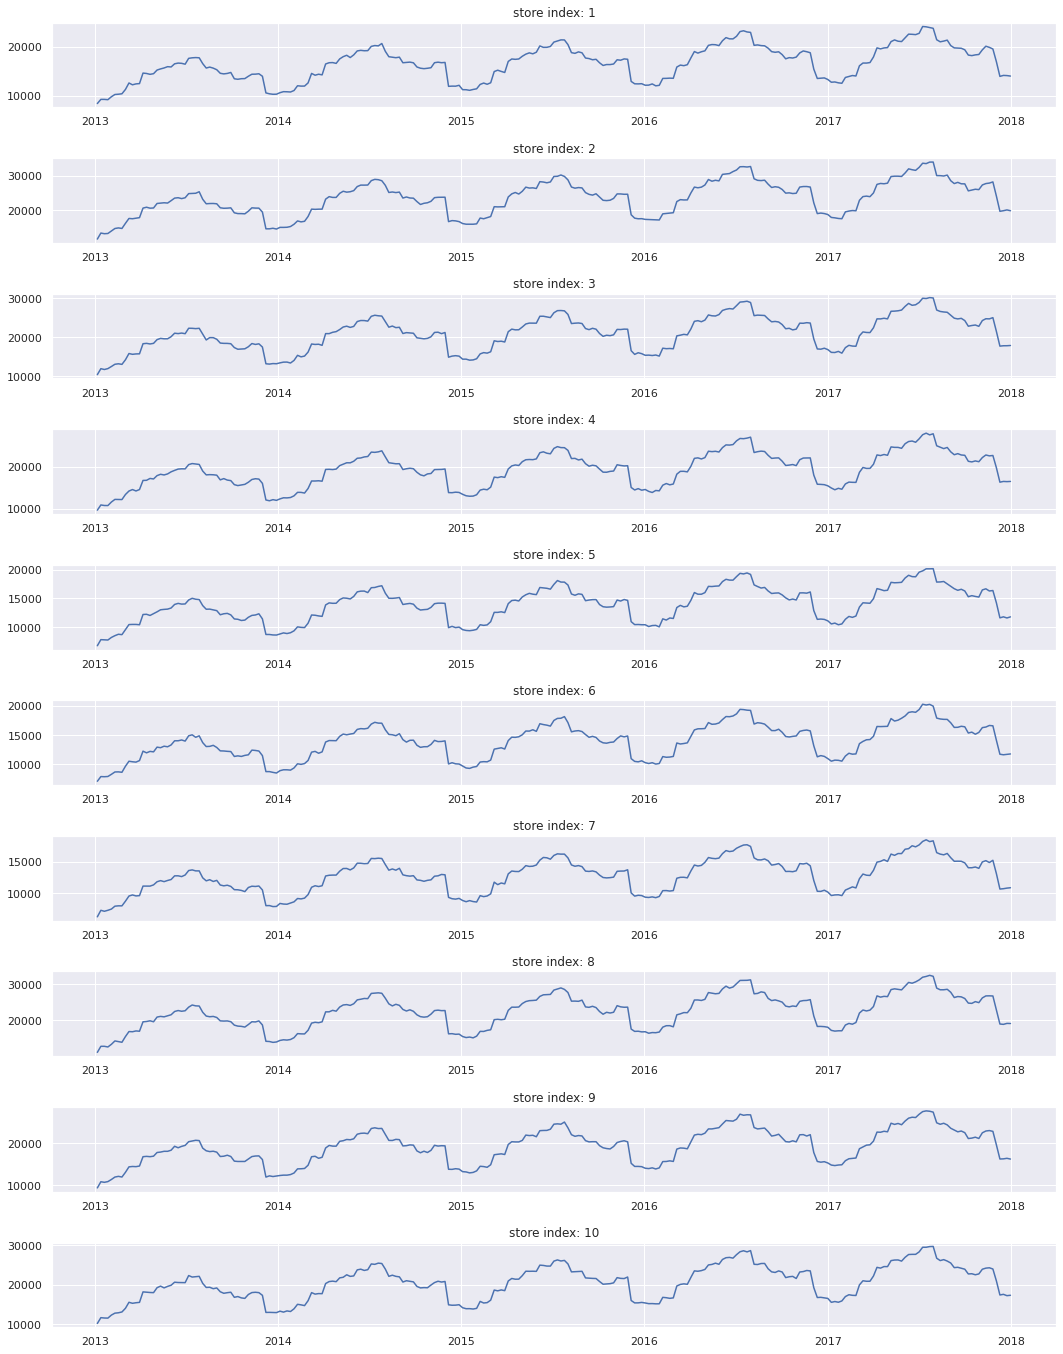

In [16]:
def plot_store_sales_by_week(df_target: pd.DataFrame) -> None:
    """週単位での集約した値を Store 単位で出力する."""
    groups = df_target.groupby(["store"])
    dfs = [(store, df.sort_index().resample("W").sum()) for store, df in groups]

    plt.figure(figsize=(18, 24))
    plt.subplots_adjust(wspace=0.4, hspace=0.6)
    rows, cols = len(dfs), 1
    for idx, (store, group) in enumerate(dfs):
        plt.subplot(rows, cols, idx + 1)
        plt.plot(group.index, group["sales"])
        plt.title(f"store index: {store}")
    plt.show()
    plt.cla()
    plt.clf()
    plt.close()


plot_store_sales_by_week(df_raw)

## 季節調整モデル

[statsmodels][statsmodels] を利用した季節成分の分解と、その結果グラフ表示です。

[statsmodels]: https://www.statsmodels.org/stable/generated/statsmodels.tsa.seasonal.seasonal_decompose.html

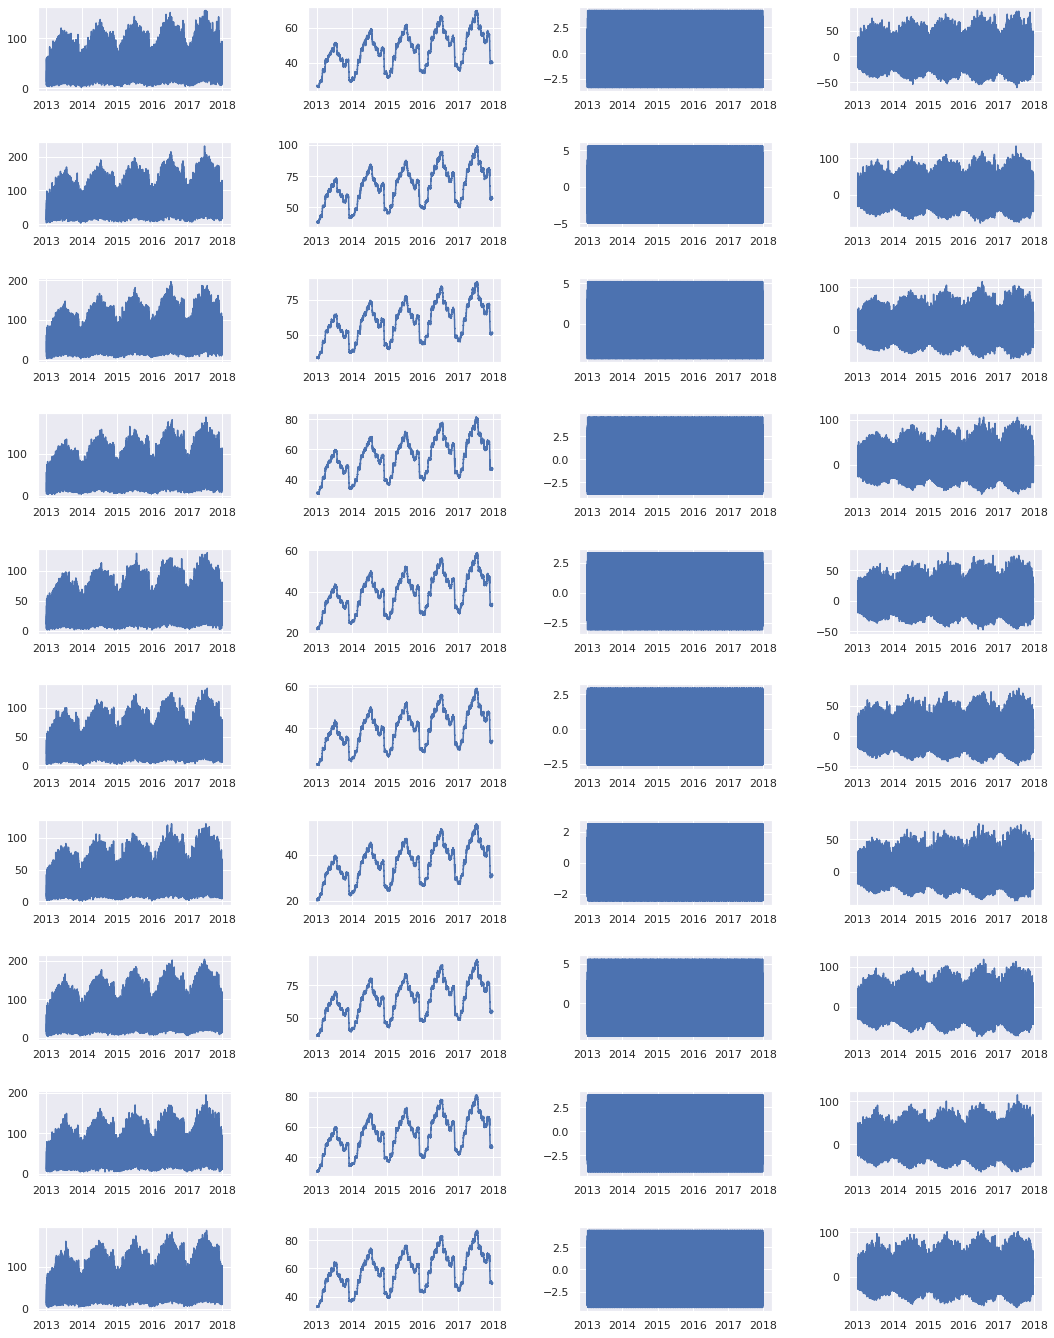

In [17]:
def plot_store_sales_using_seasonal_decomposition(df_target: pd.DataFrame) -> None:
    """データをそのまま季節成分に分解して表示."""
    groups = df_target.groupby(["store"])

    plt.figure(figsize=(18, 24))
    plt.subplots_adjust(wspace=0.4, hspace=0.6)
    rows, cols = len(groups), 4
    for idx, (store, group) in enumerate(groups):
        df = group.sort_index()
        decomposition = sm.tsa.seasonal_decompose(df["sales"], model="additive", freq=365)
        plt.subplot(rows, cols, idx * 4 + 1)
        plt.plot(df.index, decomposition.observed)
        plt.subplot(rows, cols, idx * 4 + 2)
        plt.plot(df.index, decomposition.trend)
        plt.subplot(rows, cols, idx * 4 + 3)
        plt.plot(df.index, decomposition.seasonal)
        plt.subplot(rows, cols, idx * 4 + 4)
        plt.plot(df.index, decomposition.resid)
    plt.show()
    plt.cla()
    plt.clf()
    plt.close()


plot_store_sales_using_seasonal_decomposition(df_raw)

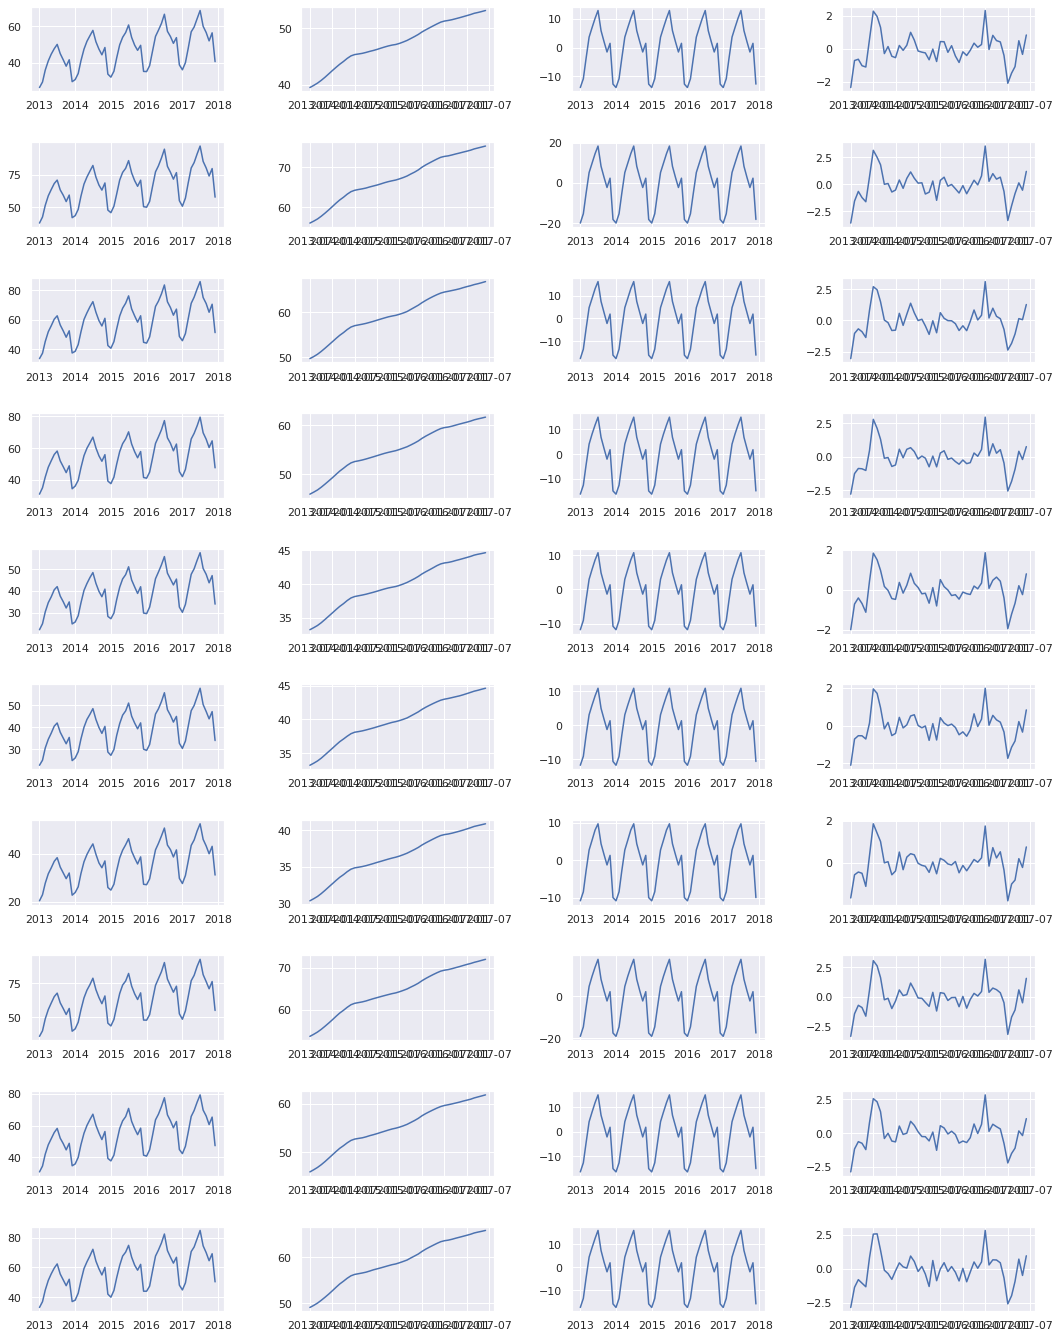

In [18]:
def plot_store_sales_using_seasonal_decomposition_by_month(
    df_target: pd.DataFrame
) -> None:
    """月の平均で季節成分に分解して表示.

    Notes:
        - `resample("MS")` とすることで、インデックスを月の始まり(1日)に設定する。
    """
    groups = df_target.groupby(["store"])
    dfs = [(store, df.sort_index().resample("MS").mean()) for store, df in groups]

    plt.figure(figsize=(18, 24))
    plt.subplots_adjust(wspace=0.4, hspace=0.6)
    rows, cols = len(dfs), 4
    for idx, (store, df) in enumerate(dfs):
        decomposition = sm.tsa.seasonal_decompose(df["sales"], model="additive", freq=12)
        plt.subplot(rows, cols, idx * 4 + 1)
        plt.plot(df.index, decomposition.observed)
        plt.subplot(rows, cols, idx * 4 + 2)
        plt.plot(df.index, decomposition.trend)
        plt.subplot(rows, cols, idx * 4 + 3)
        plt.plot(df.index, decomposition.seasonal)
        plt.subplot(rows, cols, idx * 4 + 4)
        plt.plot(df.index, decomposition.resid)


plot_store_sales_using_seasonal_decomposition_by_month(df_raw)